# Classification for Machine Learning




In [1]:
import sys
sys.path.insert(1, '../../crystal-code-tools/crystal_functions/crystal_functions/')

from file_readwrite import Crystal_output, write_cry_properties, Crystal_input, write_cry_gui,write_cry_input, Density
from execute import runcry
from convert import cry_gui2pmg

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.cif import CifWriter
from ase.visualize import view

from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core.surface import SlabGenerator
import numpy as np
import pandas as pd

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
new_atom = 'Ca'

### Read the structures from the output files and replace with new_atom
This cell generates the structures list. This contains all the 4023 structures as pymatgen structure objects

In [67]:
cry_output = Crystal_output('data/classification/ml/mgo_confrand.out')
cry_output.config_analysis()


original_structure = cry_gui2pmg('data/classification/ml/mgo_confrand.gui')
structures = []
mg_atoms = []
ca_atoms = []
for j,substitutions in enumerate(cry_output.atom_type2):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures.append(new_structure)
    mg_atoms.append((np.array(cry_output.atom_type1[j])-1).tolist())
    ca_atoms.append((np.array(cry_output.atom_type2[j])-1).tolist())

### Shells

In [409]:
shells = np.unique(np.round(structures[0].distance_matrix[0],decimals=6),return_counts=True)[0].tolist()
shells

[0.0,
 2.105,
 2.97692,
 3.645967,
 4.21,
 4.706923,
 5.156176,
 5.953839,
 6.315,
 6.656594,
 6.981495,
 7.291934,
 7.589685,
 7.876189,
 8.679137,
 8.930759,
 9.175482,
 9.873325,
 10.937901]

In [22]:
view(AseAtomsAdaptor().get_atoms(structures[0]))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/test_env...>

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# The magic happens here

Each element of the neighbours_spatial_dist_all (one element per structure) is a 2D array whose rows correspond to an atom and the array contains:
- 0 = atom number of the atom whose neighbours I'm analysing
- 1:6 = atomic numbers of the atoms in the first coord shell
- 7:19 = atomic numbers of the atoms in the second coord shell
- 20:28 = atomic numbers of the atoms in the third coord shell

These atomic numbers are ordered following a spatial analysis. They are written starting from the atoms below the atom 0 and moving upwards.

## Spatial distribution analysis

In [208]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    if np.around(az,6) ==  np.around(2*np.pi,6) \
    or np.around(az,6) ==  -np.around(2*np.pi,6):
        az = 0.
    if np.around(az,6) < 0.:
        az = np.round(2*np.pi+az,6)
    return [round(az,6), round(el,6), round(r,6)]

## THIS ONE WORKS (it scales better when a small number of shells is included)

In [406]:
max_shell = 10
centered_sph_coords = []
centered_sph_coords_structure = []
neighbours_spatial_dist = []
neighbours_spatial_dist_all = []
import time
time0 = time.time()
for k,structure in enumerate(structures[100:105]):
    time0 = time.time()
    neighbours_spatial_dist = []
    
    for j in range(structure.num_sites):
        centered_sph_coords = []
        neighbours_spatial_dist_atom = []
        
        for n in range(max_shell+1):
            atom_indices = np.where(np.round(structure.distance_matrix[j],5) == np.round(shells[n],5))[0].tolist()
            centered_sph_coords = []
            for i in atom_indices:

                translation_vector = structure.sites[j].distance_and_image(structure.sites[i])[1]
                new_cart_coords = structure.cart_coords[i]+(translation_vector*structure.lattice.abc)
                centered_cart_coords = new_cart_coords-structure.cart_coords[j] 

                centered_sph_coords.append(cart2sph(centered_cart_coords[0],centered_cart_coords[1],centered_cart_coords[2]))        

            spatial_distribution = np.argsort(np.array(centered_sph_coords)[:,1]*10 +\
                                              np.array(centered_sph_coords)[:,0])


            neighbours_spatial_dist_atom.extend((np.array(structure.atomic_numbers)[np.array(atom_indices)[spatial_distribution]]).tolist())
        neighbours_spatial_dist.append(neighbours_spatial_dist_atom)
    print(time.time()-time0)
    neighbours_spatial_dist_all.append(neighbours_spatial_dist) 
        

9.188499212265015
9.039201974868774
9.15411901473999
9.081683158874512
9.111679077148438


In [418]:
len(neighbours_spatial_dist_all[0][1])

144

In [400]:
a = np.array(neighbours_spatial_dist_all)

## THIS ONE WORKS (it scales better when a large number of shells is included)

In [407]:
max_shell = 10
centered_sph_coords = []
centered_sph_coords_structure = []
neighbours_spatial_dist = []
neighbours_spatial_dist_all = []
import time
time0 = time.time()
for k,structure in enumerate(structures[100:105]):
    time0 = time.time()
    neighbours_spatial_dist = []
    for j in range(structure.num_sites):
        centered_sph_coords = []
        for i in range(structure.num_sites):    
            translation_vector = structure.sites[j].distance_and_image(structure.sites[i])[1]
            new_cart_coords = structure.cart_coords[i]+(translation_vector*structure.lattice.abc)
            centered_cart_coords = new_cart_coords-structure.cart_coords[j] 
            centered_sph_coords.append(cart2sph(centered_cart_coords[0],centered_cart_coords[1],centered_cart_coords[2]))        

        #centered_sph_coords_all.append(centered_sph_coords)
        centered_sph_coords = np.array(centered_sph_coords)


        atoms_shell = []
        for unique in shells:
            atoms_shell.append(np.where(np.round(centered_sph_coords[:,2],5) == np.round(unique,5))[0].tolist())
        #print(atoms_shell)
        neighbours_spatial_dist_atom = []
        for shell in range(max_shell+1):
            #a = np.array(centered_sph_coords)[atoms_shell[shell]]
            spatial_distribution = np.argsort(centered_sph_coords[atoms_shell[shell]][:,1]*10 + centered_sph_coords[atoms_shell[shell]][:,0])
            #print(np.array(structure.atomic_numbers)[np.array(atoms_shell[shell])[spatial_distribution]])
            #print(np.array(atoms_shell[shell])[spatial_distribution])
            neighbours_spatial_dist_atom.extend((np.array(structure.atomic_numbers)[np.array(atoms_shell[shell])[spatial_distribution]]).tolist())
            #THIS IS THE CONTROL LINE
            #print(centered_sph_coords[np.array(atoms_shell[shell])[spatial_distribution]])
        neighbours_spatial_dist.append(neighbours_spatial_dist_atom)
    neighbours_spatial_dist_all.append(neighbours_spatial_dist)
    print(time.time()-time0)
    #centered_sph_coords_structure = np.array(centered_sph_coords_all)


7.990990877151489
7.979325771331787
8.015228033065796
8.01616907119751
7.99882698059082


## Average Ca - Ca distances

In [422]:
average_ca = []
std_average_ca = []
average_std_ca_combined = []
for n,structure in enumerate(structures):
    distance_matrix = structure.distance_matrix
    average = 0.
    std_average = []
    for i in ca_atoms[n]:
        for j in ca_atoms[n]: 
            if i != j:
                average += distance_matrix[i][j]
                std_average.append(distance_matrix[i][j])
    average_ca.append(average/(len(ca_atoms[n])**2))
    std_average_ca.append(np.std(std_average))
    average_std_ca_combined.append([average/(len(ca_atoms[n])**2),np.std(std_average)])

In [428]:
dist_std_unique, dist_std_first, dist_std_occ =  \
np.unique(np.round(np.array(average_std_ca_combined),6),axis=0,return_counts=True,return_index=True)

## Group structures

In [433]:
average_std_group = []
for unique in dist_std_unique:
    average_std_group.append(np.where(np.all(np.round(np.array(average_std_ca_combined),6) == unique,axis=1))[0].tolist())

## Plot the average Ca-Ca distance vs the Ca-Ca distance std

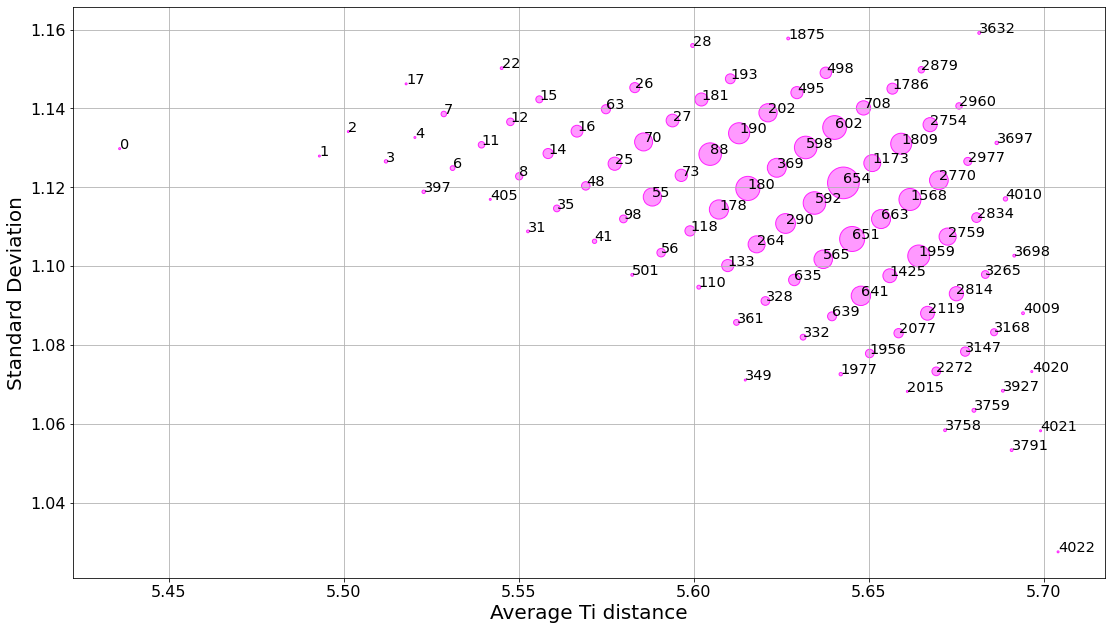

In [436]:
import matplotlib.pyplot as plt

font = {'size'   : 14.5,
       'weight': 'normal'}

plt.rc('font', **font)

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()
ax.scatter(dist_std_unique[:,0], dist_std_unique[:,1],s=dist_std_occ/max(dist_std_occ)*1000, 
           edgecolors='#ff22ff', color='#ff99ff')

label = dist_std_first

ax.set_xlabel('Average Ti distance', fontsize=20)
ax.set_ylabel('Standard Deviation', fontsize=20) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.grid()

for i, txt in enumerate(label):
    ax.annotate(txt, (dist_std_unique[i,0], dist_std_unique[i,1]),)
fig.set_size_inches(18.5, 10.5)

plt.show()

In [438]:
view(AseAtomsAdaptor().get_atoms(structures[4022]))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/test_env...>

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
